XGBoost Model - 1-HOUR Window Analysis

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 1-hour window (12 samples)

Train input shape: (15800, 4)
Test input shape: (287, 4)

Training XGBoost model...

XGBoost Performance on Full Test Set:
  Train MAE: 0.3029 °C
  Test MAE : 0.3154 °C
  Test RMSE: 0.5447 °C
  Test R²  : 0.7190

METRICS FOR 1-HOUR WINDOW (12 samples)

Model              MAE (°C)     RMSE (°C)    R²      
XGBoost            0.2074       0.2352       -5.0083 

FEATURE IMPORTANCE

Feature                   Importance  
----------------------------------------
indoor_temp_t-1           0.8270      
outdoor_temp_t-1          0.1249      
satellite_value_t-1       0.0395      
supply_air_t-1            0.0086      


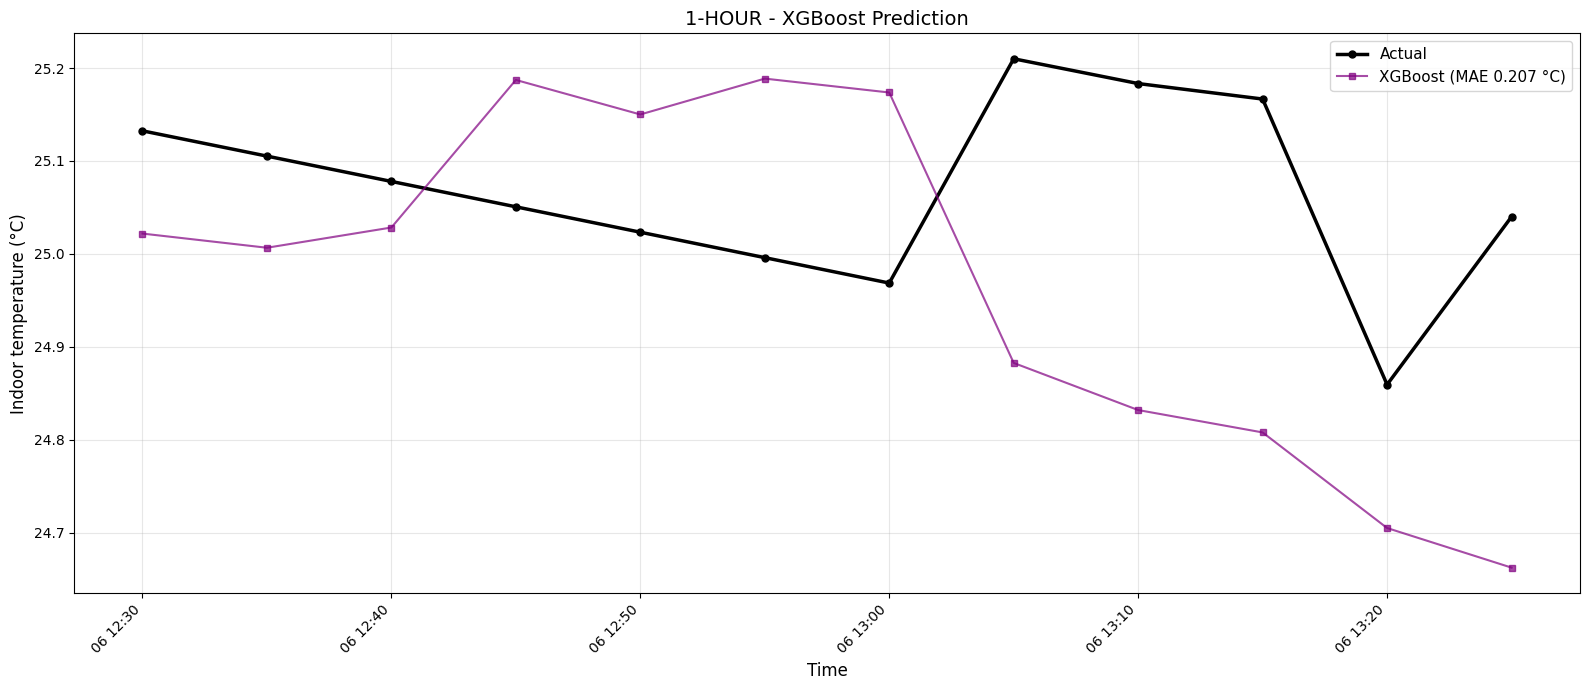

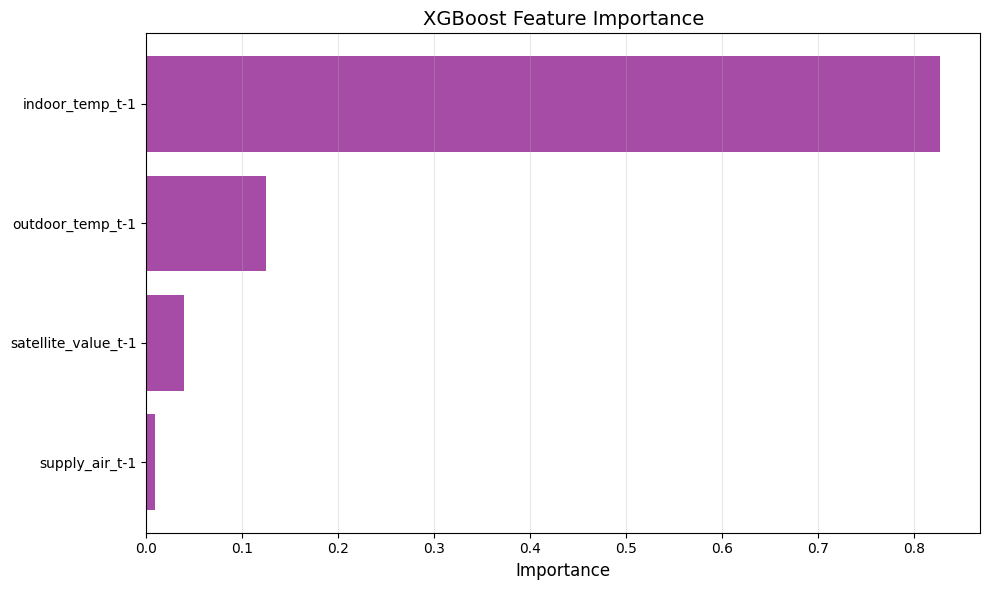


ANALYSIS COMPLETE FOR 1-HOUR WINDOW

XGBoost Results Summary:
  Full test MAE : 0.3154 °C
  Window MAE    : 0.2074 °C
  Window RMSE   : 0.2352 °C
  Window R²     : -5.0083

Compare these results with FNN, ODE, and PINN models!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "1-hour"
WINDOW_SAMPLES = 12  # 1 hour = 12 samples (5-min intervals)

print("="*80)
print(f"XGBoost Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE DATA FOR XGBOOST (ONE-STEP PREDICTION)
# =========================================================

def prepare_one_step_dataset(df):
    """Same preparation as FNN/PINN models"""
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values  # drop first row (NaN after shift)
    target_vector = df["indoor_temp"].iloc[1:].values  # shape (N,)
    return input_matrix, target_vector

# Build train and test arrays
train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"Train input shape: {train_inputs_np.shape}")
print(f"Test input shape: {test_inputs_np.shape}")

# Scale inputs (XGBoost can work without scaling, but we do it for consistency)
input_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)

# =========================================================
# TRAIN XGBOOST MODEL
# =========================================================

print("\nTraining XGBoost model...")

# XGBoost configuration
xgb_model = XGBRegressor(
    n_estimators=500,           # More trees for better performance
    max_depth=4,                # Moderate depth to avoid overfitting
    learning_rate=0.05,         # Lower learning rate with more trees
    subsample=0.8,              # Random sampling of training data
    colsample_bytree=0.8,       # Random sampling of features
    reg_lambda=1.0,             # L2 regularization
    reg_alpha=0.1,              # L1 regularization
    random_state=SEED,
    objective="reg:squarederror",
    n_jobs=-1                   # Use all CPU cores
)

# Fit model
xgb_model.fit(
    train_inputs_scaled, 
    train_targets_np,
    eval_set=[(test_inputs_scaled, test_targets_np)],
    verbose=False
)

# Make predictions
xgb_pred_train = xgb_model.predict(train_inputs_scaled)
xgb_pred_test = xgb_model.predict(test_inputs_scaled)

# =========================================================
# FULL TEST SET METRICS
# =========================================================

xgb_mae_full = mean_absolute_error(test_targets_np, xgb_pred_test)
xgb_rmse_full = np.sqrt(mean_squared_error(test_targets_np, xgb_pred_test))
xgb_r2_full = r2_score(test_targets_np, xgb_pred_test)
xgb_train_mae = mean_absolute_error(train_targets_np, xgb_pred_train)

print("\nXGBoost Performance on Full Test Set:")
print(f"  Train MAE: {xgb_train_mae:.4f} °C")
print(f"  Test MAE : {xgb_mae_full:.4f} °C")
print(f"  Test RMSE: {xgb_rmse_full:.4f} °C")
print(f"  Test R²  : {xgb_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(test_targets_np))

xgb_mae_w = mean_absolute_error(test_targets_np[:window_size], xgb_pred_test[:window_size])
xgb_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], xgb_pred_test[:window_size]))
xgb_r2_w = r2_score(test_targets_np[:window_size], xgb_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'XGBoost':<18} {xgb_mae_w:<12.4f} {xgb_rmse_w:<12.4f} {xgb_r2_w:<8.4f}")

# =========================================================
# FEATURE IMPORTANCE
# =========================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

feature_names = ["supply_air_t-1", "outdoor_temp_t-1", "satellite_value_t-1", "indoor_temp_t-1"]
importance = xgb_model.feature_importances_

print(f"\n{'Feature':<25} {'Importance':<12}")
print("-"*40)
for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {imp:<12.4f}")

# =========================================================
# VISUALIZATION
# =========================================================

y_true_w = test_targets_np[:window_size]
xgb_pred_w = xgb_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values

plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, xgb_pred_w, "s-", label=f"XGBoost (MAE {xgb_mae_w:.3f} °C)", 
         color="purple", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - XGBoost Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='purple', alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nXGBoost Results Summary:")
print(f"  Full test MAE : {xgb_mae_full:.4f} °C")
print(f"  Window MAE    : {xgb_mae_w:.4f} °C")
print(f"  Window RMSE   : {xgb_rmse_w:.4f} °C")
print(f"  Window R²     : {xgb_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, and PINN models!")
print("="*80)

XGBoost Model - 6-HOUR Window Analysis

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 6-hour window (72 samples)

Train input shape: (15800, 4)
Test input shape: (287, 4)

Training XGBoost model...

XGBoost Performance on Full Test Set:
  Train MAE: 0.3029 °C
  Test MAE : 0.3154 °C
  Test RMSE: 0.5447 °C
  Test R²  : 0.7190

METRICS FOR 6-HOUR WINDOW (72 samples)

Model              MAE (°C)     RMSE (°C)    R²      
XGBoost            0.3309       0.5259       0.4591  

FEATURE IMPORTANCE

Feature                   Importance  
----------------------------------------
indoor_temp_t-1           0.8270      
outdoor_temp_t-1          0.1249      
satellite_value_t-1       0.0395      
supply_air_t-1            0.0086      


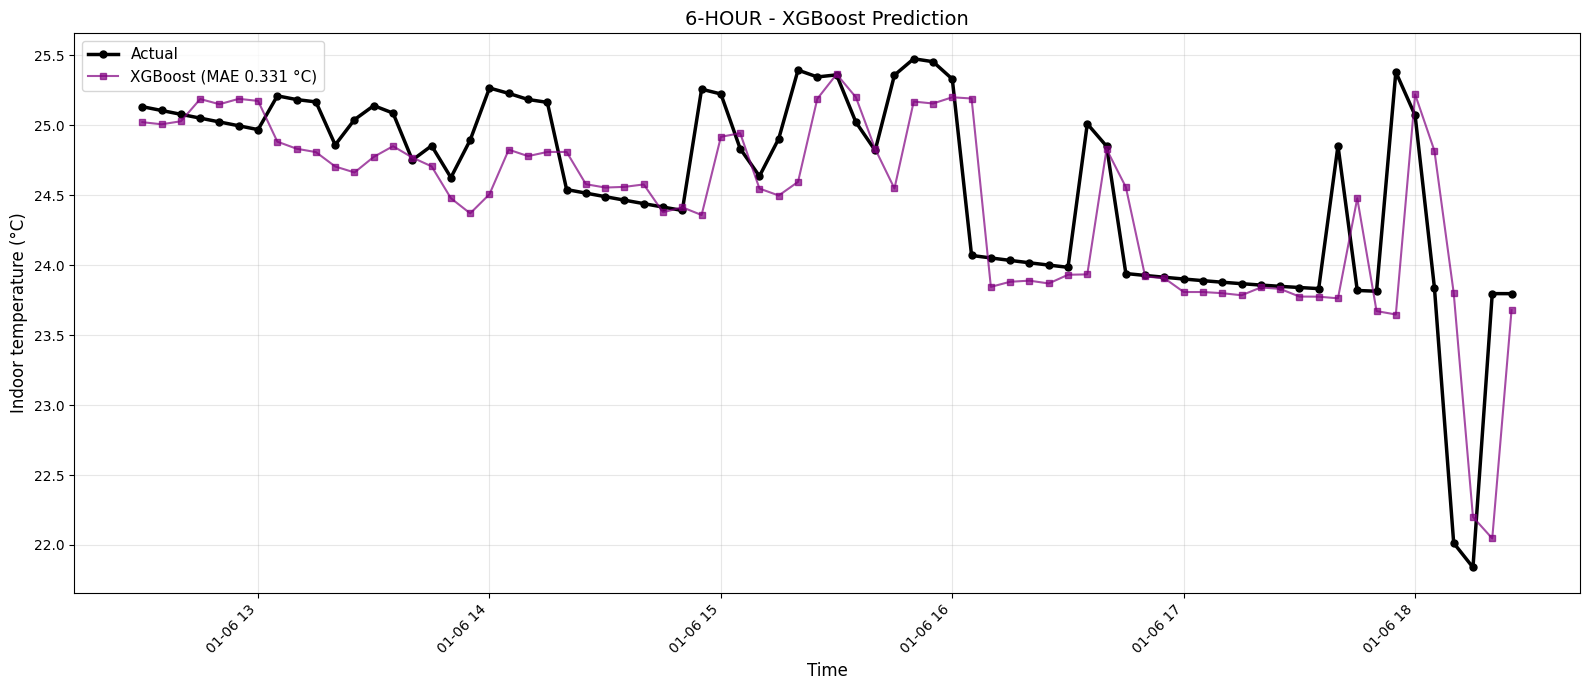

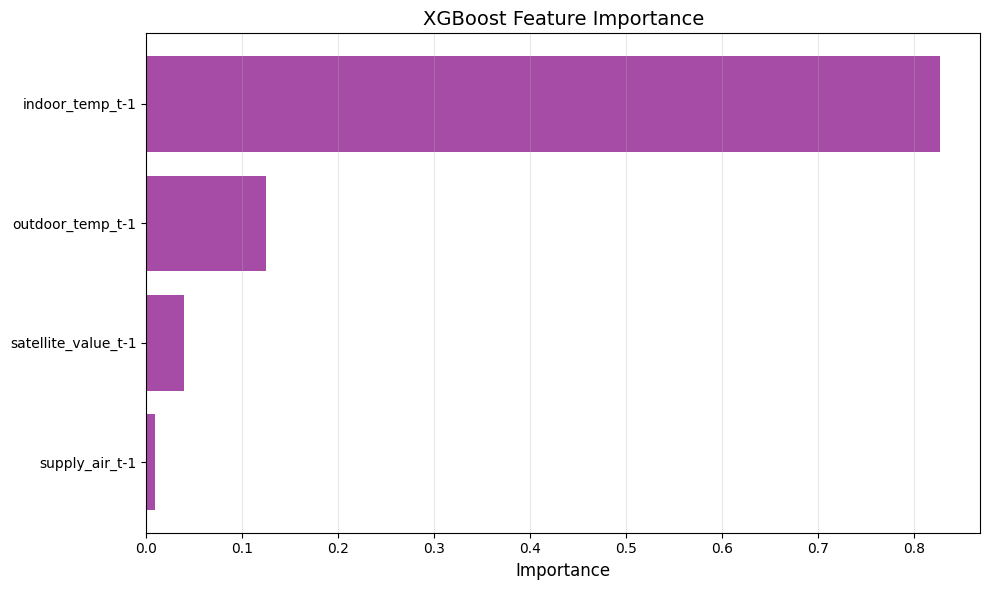


ANALYSIS COMPLETE FOR 6-HOUR WINDOW

XGBoost Results Summary:
  Full test MAE : 0.3154 °C
  Window MAE    : 0.3309 °C
  Window RMSE   : 0.5259 °C
  Window R²     : 0.4591

Compare these results with FNN, ODE, and PINN models!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "6-hour"
WINDOW_SAMPLES = 72  # 1 hour = 12 samples (5-min intervals)

print("="*80)
print(f"XGBoost Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE DATA FOR XGBOOST (ONE-STEP PREDICTION)
# =========================================================

def prepare_one_step_dataset(df):
    """Same preparation as FNN/PINN models"""
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values  # drop first row (NaN after shift)
    target_vector = df["indoor_temp"].iloc[1:].values  # shape (N,)
    return input_matrix, target_vector

# Build train and test arrays
train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"Train input shape: {train_inputs_np.shape}")
print(f"Test input shape: {test_inputs_np.shape}")

# Scale inputs (XGBoost can work without scaling, but we do it for consistency)
input_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)

# =========================================================
# TRAIN XGBOOST MODEL
# =========================================================

print("\nTraining XGBoost model...")

# XGBoost configuration
xgb_model = XGBRegressor(
    n_estimators=500,           # More trees for better performance
    max_depth=4,                # Moderate depth to avoid overfitting
    learning_rate=0.05,         # Lower learning rate with more trees
    subsample=0.8,              # Random sampling of training data
    colsample_bytree=0.8,       # Random sampling of features
    reg_lambda=1.0,             # L2 regularization
    reg_alpha=0.1,              # L1 regularization
    random_state=SEED,
    objective="reg:squarederror",
    n_jobs=-1                   # Use all CPU cores
)

# Fit model
xgb_model.fit(
    train_inputs_scaled, 
    train_targets_np,
    eval_set=[(test_inputs_scaled, test_targets_np)],
    verbose=False
)

# Make predictions
xgb_pred_train = xgb_model.predict(train_inputs_scaled)
xgb_pred_test = xgb_model.predict(test_inputs_scaled)

# =========================================================
# FULL TEST SET METRICS
# =========================================================

xgb_mae_full = mean_absolute_error(test_targets_np, xgb_pred_test)
xgb_rmse_full = np.sqrt(mean_squared_error(test_targets_np, xgb_pred_test))
xgb_r2_full = r2_score(test_targets_np, xgb_pred_test)
xgb_train_mae = mean_absolute_error(train_targets_np, xgb_pred_train)

print("\nXGBoost Performance on Full Test Set:")
print(f"  Train MAE: {xgb_train_mae:.4f} °C")
print(f"  Test MAE : {xgb_mae_full:.4f} °C")
print(f"  Test RMSE: {xgb_rmse_full:.4f} °C")
print(f"  Test R²  : {xgb_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(test_targets_np))

xgb_mae_w = mean_absolute_error(test_targets_np[:window_size], xgb_pred_test[:window_size])
xgb_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], xgb_pred_test[:window_size]))
xgb_r2_w = r2_score(test_targets_np[:window_size], xgb_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'XGBoost':<18} {xgb_mae_w:<12.4f} {xgb_rmse_w:<12.4f} {xgb_r2_w:<8.4f}")

# =========================================================
# FEATURE IMPORTANCE
# =========================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

feature_names = ["supply_air_t-1", "outdoor_temp_t-1", "satellite_value_t-1", "indoor_temp_t-1"]
importance = xgb_model.feature_importances_

print(f"\n{'Feature':<25} {'Importance':<12}")
print("-"*40)
for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {imp:<12.4f}")

# =========================================================
# VISUALIZATION
# =========================================================

y_true_w = test_targets_np[:window_size]
xgb_pred_w = xgb_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values

plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, xgb_pred_w, "s-", label=f"XGBoost (MAE {xgb_mae_w:.3f} °C)", 
         color="purple", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - XGBoost Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='purple', alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nXGBoost Results Summary:")
print(f"  Full test MAE : {xgb_mae_full:.4f} °C")
print(f"  Window MAE    : {xgb_mae_w:.4f} °C")
print(f"  Window RMSE   : {xgb_rmse_w:.4f} °C")
print(f"  Window R²     : {xgb_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, and PINN models!")
print("="*80)

XGBoost Model - 12-HOUR Window Analysis

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 12-hour window (144 samples)

Train input shape: (15800, 4)
Test input shape: (287, 4)

Training XGBoost model...

XGBoost Performance on Full Test Set:
  Train MAE: 0.3029 °C
  Test MAE : 0.3154 °C
  Test RMSE: 0.5447 °C
  Test R²  : 0.7190

METRICS FOR 12-HOUR WINDOW (144 samples)

Model              MAE (°C)     RMSE (°C)    R²      
XGBoost            0.3120       0.5096       0.4638  

FEATURE IMPORTANCE

Feature                   Importance  
----------------------------------------
indoor_temp_t-1           0.8270      
outdoor_temp_t-1          0.1249      
satellite_value_t-1       0.0395      
supply_air_t-1            0.0086      


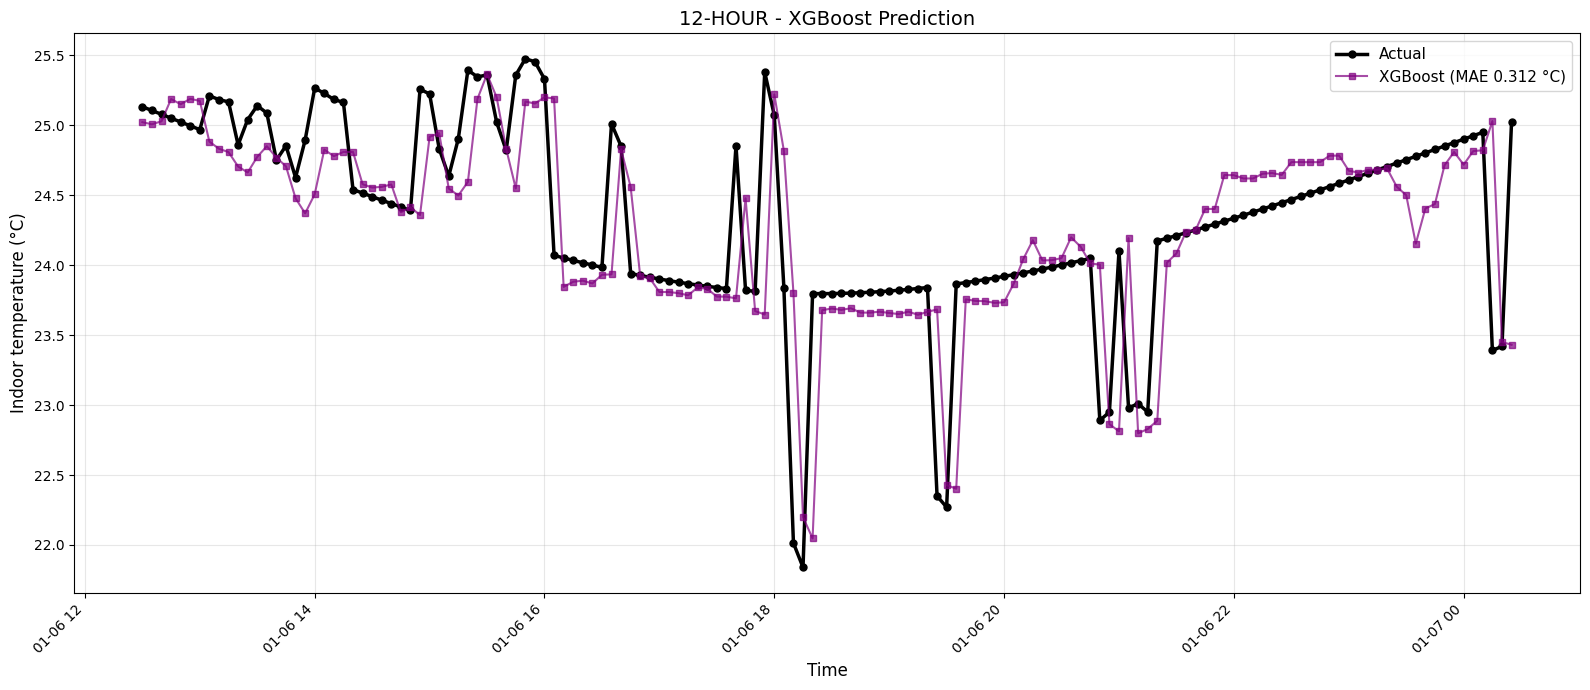

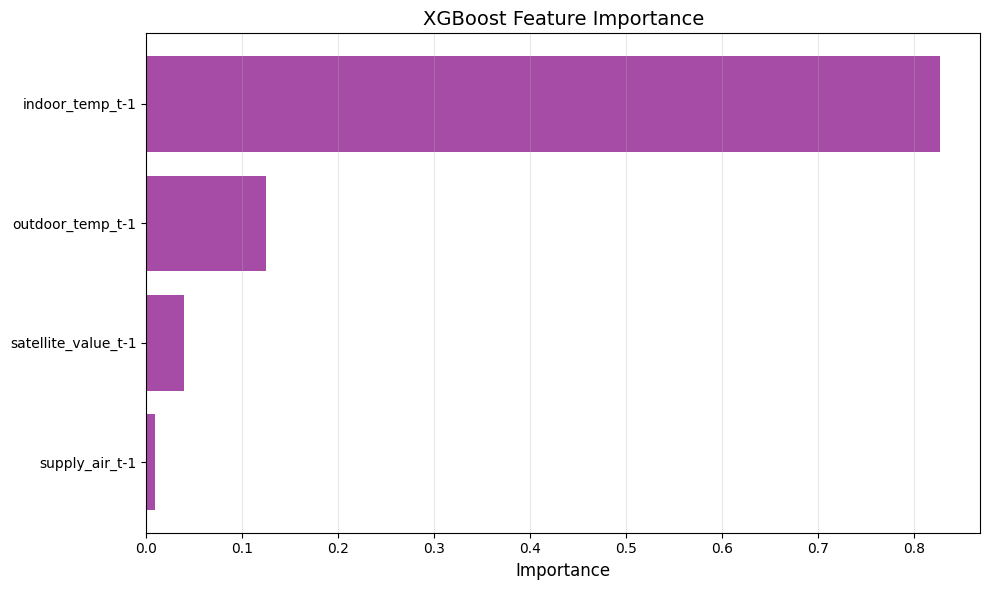


ANALYSIS COMPLETE FOR 12-HOUR WINDOW

XGBoost Results Summary:
  Full test MAE : 0.3154 °C
  Window MAE    : 0.3120 °C
  Window RMSE   : 0.5096 °C
  Window R²     : 0.4638

Compare these results with FNN, ODE, and PINN models!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "12-hour"
WINDOW_SAMPLES = 144  # 1 hour = 12 samples (5-min intervals)

print("="*80)
print(f"XGBoost Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE DATA FOR XGBOOST (ONE-STEP PREDICTION)
# =========================================================

def prepare_one_step_dataset(df):
    """Same preparation as FNN/PINN models"""
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values  # drop first row (NaN after shift)
    target_vector = df["indoor_temp"].iloc[1:].values  # shape (N,)
    return input_matrix, target_vector

# Build train and test arrays
train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"Train input shape: {train_inputs_np.shape}")
print(f"Test input shape: {test_inputs_np.shape}")

# Scale inputs (XGBoost can work without scaling, but we do it for consistency)
input_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)

# =========================================================
# TRAIN XGBOOST MODEL
# =========================================================

print("\nTraining XGBoost model...")

# XGBoost configuration
xgb_model = XGBRegressor(
    n_estimators=500,           # More trees for better performance
    max_depth=4,                # Moderate depth to avoid overfitting
    learning_rate=0.05,         # Lower learning rate with more trees
    subsample=0.8,              # Random sampling of training data
    colsample_bytree=0.8,       # Random sampling of features
    reg_lambda=1.0,             # L2 regularization
    reg_alpha=0.1,              # L1 regularization
    random_state=SEED,
    objective="reg:squarederror",
    n_jobs=-1                   # Use all CPU cores
)

# Fit model
xgb_model.fit(
    train_inputs_scaled, 
    train_targets_np,
    eval_set=[(test_inputs_scaled, test_targets_np)],
    verbose=False
)

# Make predictions
xgb_pred_train = xgb_model.predict(train_inputs_scaled)
xgb_pred_test = xgb_model.predict(test_inputs_scaled)

# =========================================================
# FULL TEST SET METRICS
# =========================================================

xgb_mae_full = mean_absolute_error(test_targets_np, xgb_pred_test)
xgb_rmse_full = np.sqrt(mean_squared_error(test_targets_np, xgb_pred_test))
xgb_r2_full = r2_score(test_targets_np, xgb_pred_test)
xgb_train_mae = mean_absolute_error(train_targets_np, xgb_pred_train)

print("\nXGBoost Performance on Full Test Set:")
print(f"  Train MAE: {xgb_train_mae:.4f} °C")
print(f"  Test MAE : {xgb_mae_full:.4f} °C")
print(f"  Test RMSE: {xgb_rmse_full:.4f} °C")
print(f"  Test R²  : {xgb_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(test_targets_np))

xgb_mae_w = mean_absolute_error(test_targets_np[:window_size], xgb_pred_test[:window_size])
xgb_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], xgb_pred_test[:window_size]))
xgb_r2_w = r2_score(test_targets_np[:window_size], xgb_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'XGBoost':<18} {xgb_mae_w:<12.4f} {xgb_rmse_w:<12.4f} {xgb_r2_w:<8.4f}")

# =========================================================
# FEATURE IMPORTANCE
# =========================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

feature_names = ["supply_air_t-1", "outdoor_temp_t-1", "satellite_value_t-1", "indoor_temp_t-1"]
importance = xgb_model.feature_importances_

print(f"\n{'Feature':<25} {'Importance':<12}")
print("-"*40)
for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {imp:<12.4f}")

# =========================================================
# VISUALIZATION
# =========================================================

y_true_w = test_targets_np[:window_size]
xgb_pred_w = xgb_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values

plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, xgb_pred_w, "s-", label=f"XGBoost (MAE {xgb_mae_w:.3f} °C)", 
         color="purple", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - XGBoost Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='purple', alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nXGBoost Results Summary:")
print(f"  Full test MAE : {xgb_mae_full:.4f} °C")
print(f"  Window MAE    : {xgb_mae_w:.4f} °C")
print(f"  Window RMSE   : {xgb_rmse_w:.4f} °C")
print(f"  Window R²     : {xgb_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, and PINN models!")
print("="*80)

XGBoost Model - 24-HOUR Window Analysis

Total samples: 16089
Date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
Training samples: 15801
Testing samples : 288
Analyzing 24-hour window (288 samples)

Train input shape: (15800, 4)
Test input shape: (287, 4)

Training XGBoost model...

XGBoost Performance on Full Test Set:
  Train MAE: 0.3029 °C
  Test MAE : 0.3154 °C
  Test RMSE: 0.5447 °C
  Test R²  : 0.7190

METRICS FOR 24-HOUR WINDOW (288 samples)

Model              MAE (°C)     RMSE (°C)    R²      
XGBoost            0.3154       0.5447       0.7190  

FEATURE IMPORTANCE

Feature                   Importance  
----------------------------------------
indoor_temp_t-1           0.8270      
outdoor_temp_t-1          0.1249      
satellite_value_t-1       0.0395      
supply_air_t-1            0.0086      


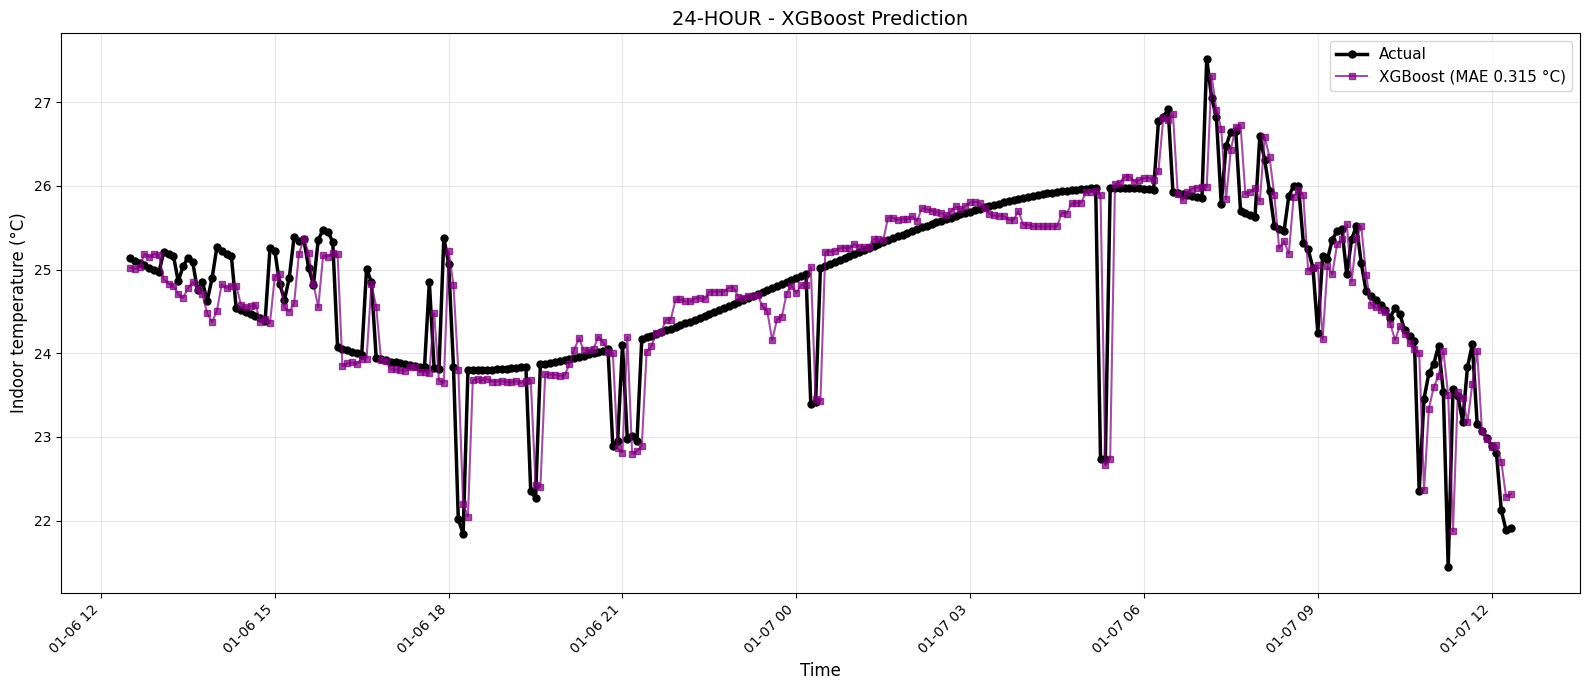

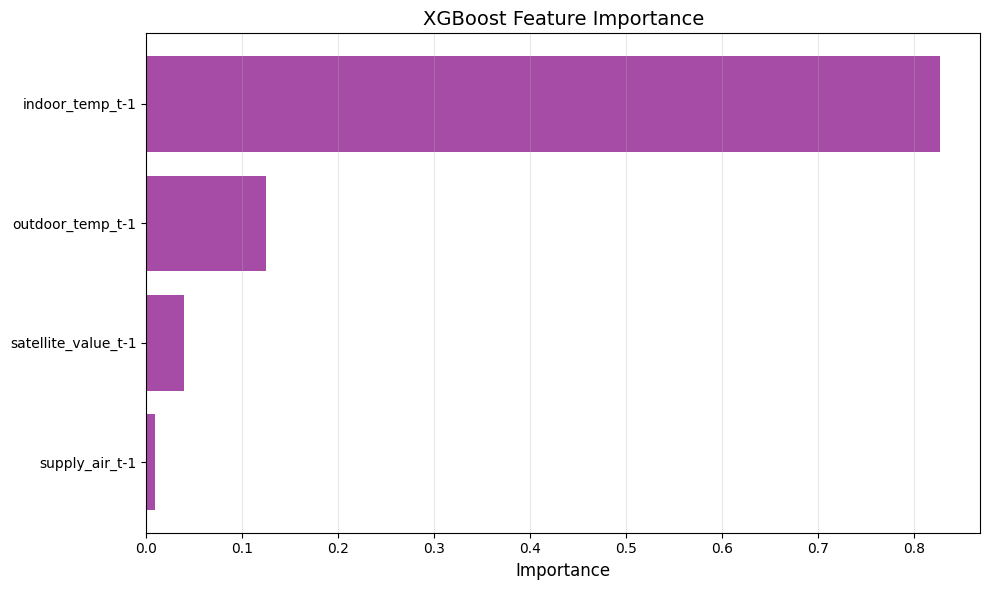


ANALYSIS COMPLETE FOR 24-HOUR WINDOW

XGBoost Results Summary:
  Full test MAE : 0.3154 °C
  Window MAE    : 0.3154 °C
  Window RMSE   : 0.5447 °C
  Window R²     : 0.7190

Compare these results with FNN, ODE, and PINN models!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# BASIC SETTINGS
# -----------------------------
plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          # 5-min data
TEST_DAYS = 1                    # last 1 day as test
SAMPLES_PER_DAY = 288            # 24*60 / 5
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

# WINDOW SPECIFICATION - 1 HOUR
WINDOW_NAME = "24-hour"
WINDOW_SAMPLES = 288  # 1 hour = 12 samples (5-min intervals)

print("="*80)
print(f"XGBoost Model - {WINDOW_NAME.upper()} Window Analysis")
print("="*80)

try:
    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    # Keep only rows where all key variables are present
    full_data = full_data.dropna(
        subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    ).reset_index(drop=True)

    if len(full_data) < TEST_SIZE:
        raise ValueError(f"Dataset too small! Need at least {TEST_SIZE} rows, got {len(full_data)}")

    print(f"\nTotal samples: {len(full_data)}")
    print(f"Date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR: Data file '{DATA_FILE}' not found in current directory.")
    raise
except Exception as e:
    print("ERROR while loading data:", e)
    raise

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples : {len(test_data)}")
print(f"Analyzing {WINDOW_NAME} window ({WINDOW_SAMPLES} samples)\n")

# =========================================================
# PREPARE DATA FOR XGBOOST (ONE-STEP PREDICTION)
# =========================================================

def prepare_one_step_dataset(df):
    """Same preparation as FNN/PINN models"""
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values  # drop first row (NaN after shift)
    target_vector = df["indoor_temp"].iloc[1:].values  # shape (N,)
    return input_matrix, target_vector

# Build train and test arrays
train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"Train input shape: {train_inputs_np.shape}")
print(f"Test input shape: {test_inputs_np.shape}")

# Scale inputs (XGBoost can work without scaling, but we do it for consistency)
input_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)

# =========================================================
# TRAIN XGBOOST MODEL
# =========================================================

print("\nTraining XGBoost model...")

# XGBoost configuration
xgb_model = XGBRegressor(
    n_estimators=500,           # More trees for better performance
    max_depth=4,                # Moderate depth to avoid overfitting
    learning_rate=0.05,         # Lower learning rate with more trees
    subsample=0.8,              # Random sampling of training data
    colsample_bytree=0.8,       # Random sampling of features
    reg_lambda=1.0,             # L2 regularization
    reg_alpha=0.1,              # L1 regularization
    random_state=SEED,
    objective="reg:squarederror",
    n_jobs=-1                   # Use all CPU cores
)

# Fit model
xgb_model.fit(
    train_inputs_scaled, 
    train_targets_np,
    eval_set=[(test_inputs_scaled, test_targets_np)],
    verbose=False
)

# Make predictions
xgb_pred_train = xgb_model.predict(train_inputs_scaled)
xgb_pred_test = xgb_model.predict(test_inputs_scaled)

# =========================================================
# FULL TEST SET METRICS
# =========================================================

xgb_mae_full = mean_absolute_error(test_targets_np, xgb_pred_test)
xgb_rmse_full = np.sqrt(mean_squared_error(test_targets_np, xgb_pred_test))
xgb_r2_full = r2_score(test_targets_np, xgb_pred_test)
xgb_train_mae = mean_absolute_error(train_targets_np, xgb_pred_train)

print("\nXGBoost Performance on Full Test Set:")
print(f"  Train MAE: {xgb_train_mae:.4f} °C")
print(f"  Test MAE : {xgb_mae_full:.4f} °C")
print(f"  Test RMSE: {xgb_rmse_full:.4f} °C")
print(f"  Test R²  : {xgb_r2_full:.4f}")

# =========================================================
# WINDOW-SPECIFIC METRICS
# =========================================================

print("\n" + "="*80)
print(f"METRICS FOR {WINDOW_NAME.upper()} WINDOW ({WINDOW_SAMPLES} samples)")
print("="*80)

# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(test_targets_np))

xgb_mae_w = mean_absolute_error(test_targets_np[:window_size], xgb_pred_test[:window_size])
xgb_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], xgb_pred_test[:window_size]))
xgb_r2_w = r2_score(test_targets_np[:window_size], xgb_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'XGBoost':<18} {xgb_mae_w:<12.4f} {xgb_rmse_w:<12.4f} {xgb_r2_w:<8.4f}")

# =========================================================
# FEATURE IMPORTANCE
# =========================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

feature_names = ["supply_air_t-1", "outdoor_temp_t-1", "satellite_value_t-1", "indoor_temp_t-1"]
importance = xgb_model.feature_importances_

print(f"\n{'Feature':<25} {'Importance':<12}")
print("-"*40)
for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {imp:<12.4f}")

# =========================================================
# VISUALIZATION
# =========================================================

y_true_w = test_targets_np[:window_size]
xgb_pred_w = xgb_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values

plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, xgb_pred_w, "s-", label=f"XGBoost (MAE {xgb_mae_w:.3f} °C)", 
         color="purple", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} - XGBoost Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='purple', alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =========================================================
# COMPARISON SUMMARY
# =========================================================

print("\n" + "="*80)
print(f"ANALYSIS COMPLETE FOR {WINDOW_NAME.upper()} WINDOW")
print("="*80)
print(f"\nXGBoost Results Summary:")
print(f"  Full test MAE : {xgb_mae_full:.4f} °C")
print(f"  Window MAE    : {xgb_mae_w:.4f} °C")
print(f"  Window RMSE   : {xgb_rmse_w:.4f} °C")
print(f"  Window R²     : {xgb_r2_w:.4f}")
print("\nCompare these results with FNN, ODE, and PINN models!")
print("="*80)